In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
data = pd.read_csv('SONY.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
df = data

In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,45.860001,45.959999,45.330002,45.560001,45.560001,2192700
2017-12-04,46.250000,46.340000,45.750000,45.779999,45.779999,992800
2017-12-05,45.759998,46.200001,45.730000,45.869999,45.869999,554900
2017-12-06,44.990002,45.009998,44.650002,44.910000,44.910000,970700
2017-12-07,45.209999,45.849998,45.209999,45.750000,45.750000,809200
...,...,...,...,...,...,...
2023-05-09,92.820000,94.089996,92.820000,93.900002,93.900002,866000
2023-05-10,93.000000,93.519997,92.400002,93.430000,93.430000,755600
2023-05-11,93.610001,93.610001,92.650002,93.209999,93.209999,462000


In [4]:
# Create a new column for the target variable, which is the future stock price
data['FuturePrice'] = data['Close'].shift(-30)

# Remove rows with missing values
data = data.dropna()

# Select the relevant features for prediction (you can add more if needed)
features = ['Close']

# Split the data into features (X) and target variable (y)
X = data[features]
y = data['FuturePrice']

In [5]:
# Split the data into train, test, and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.2857, random_state=42)

In [6]:
# Initialize the random forest model
model = RandomForestRegressor(n_estimators=100)

# Fit the model on the training data
model.fit(X_train, y_train)

RandomForestRegressor()

In [7]:
X_train

,Close
Date,
2022-04-25,87.580002
2021-01-27,97.000000
2019-04-01,42.980000
2019-05-03,52.250000
2018-06-21,49.220001
...,...
2022-04-08,98.269997
2022-05-31,94.070000
2023-01-25,89.550003


In [8]:
# Get the last available stock price for prediction
last_price = X_train.tail(1)

# Create a date range for the next 30 days
next_30_days = pd.date_range(start=df.index[-1], periods=30, freq='B')

In [9]:
# Predict the stock prices for the next 30 days
predicted_prices = []
for day in next_30_days:
    predicted_price = model.predict(last_price)
    predicted_prices.append(predicted_price[0])
    last_price = pd.DataFrame({features[0]: [predicted_price[0]]})

In [10]:
predicted_data = pd.DataFrame({'Date': next_30_days[:len(X_val)], 'PredictedPrice': predicted_prices})

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val[:len(predicted_data)], predicted_data['PredictedPrice'])
mape_percent = mape * 100
print('Mean Absolute Percentage Error (MAPE):', mape_percent, '%')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val[:len(predicted_data)], predicted_data['PredictedPrice']))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MSE
mse = mean_squared_error(y_val[:len(predicted_data)], predicted_data['PredictedPrice'])
print('Mean Squared Error (MSE):', mse)

Mean Absolute Percentage Error (MAPE): 59.7945614432973 %
Root Mean Squared Error (RMSE): 39.331645535113566
Mean Squared Error (MSE): 1546.978340499819


In [11]:
data = data.reset_index()

# Combine the actual and predicted data
combined_data = pd.merge(data[['Date', 'Close']], predicted_data, on='Date', how='outer')


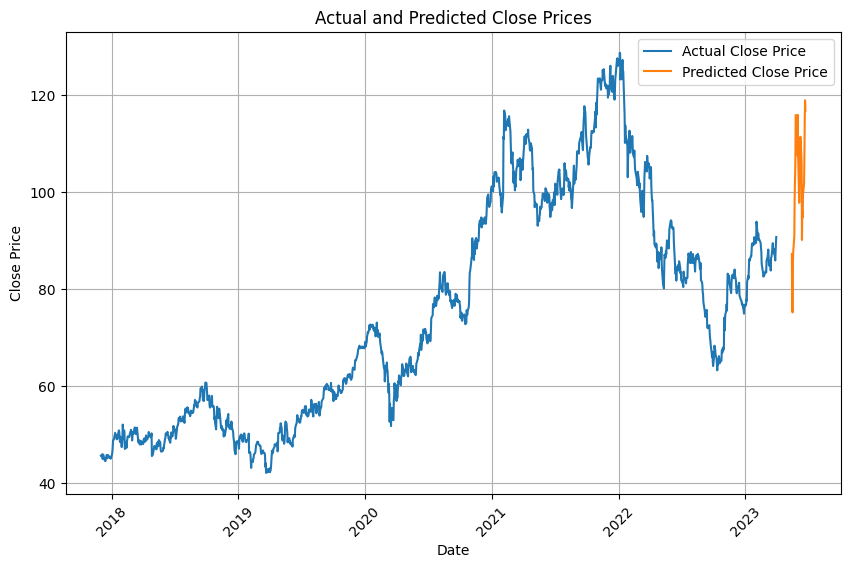

In [12]:
# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(combined_data['Date'], combined_data['Close'], label='Actual Close Price')
plt.plot(combined_data['Date'], combined_data['PredictedPrice'], label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual and Predicted Close Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()